# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'miniature_pinscher_145.jpg'

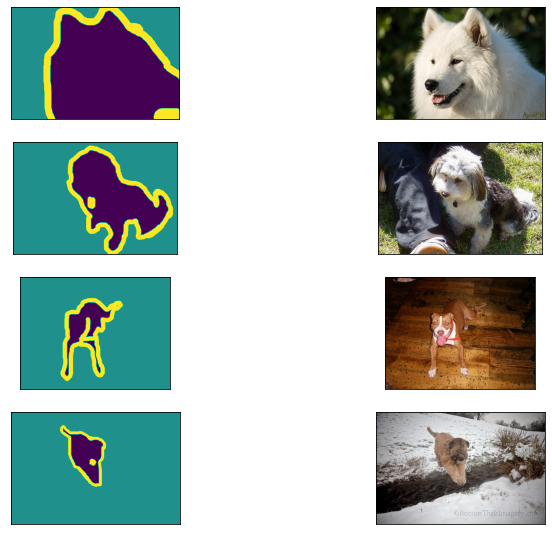

In [9]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(5, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(5, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [25]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdata-sx'
# training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation',repo_version='latest')
training_image = sagemaker.image_uris.retrieve('semantic-segmentation', boto3.Session().region_name, py_version='latest')
print(training_image)

644912444149.dkr.ecr.eu-west-2.amazonaws.com/semantic-segmentation:1


In [26]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [27]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:37<00:00, 197.86it/s]


In [28]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [29]:
print(len(train_annots), len(train_images))

5520 5520


# Uploading Data to S3

In [31]:
%%time
sess = sagemaker.Session()

print('Starting upload..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 1min 36s, sys: 7.92 s, total: 1min 44s
Wall time: 11min 48s


In [32]:
s3_validation_annotation_path

's3://petsdata-sx/validation_annotation'

# SageMaker Estimator

In [34]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://petsdata-sx/output',
    sagemaker_session=sess
)

# Hyperparameters

In [35]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

# Data Channels

In [37]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

In [38]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In [40]:
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7fb131375358>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7fb1313754e0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7fb131375400>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7fb1313754a8>}

# Model Training

In [41]:
model.fit(inputs=data_channels, logs=True)

2022-02-15 11:22:08 Starting - Starting the training job...
2022-02-15 11:22:34 Starting - Preparing the instances for trainingProfilerReport-1644924128: InProgress
.........
2022-02-15 11:23:54 Downloading - Downloading input data.................Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script

2022-02-15 11:26:52 Training - Training image download completed. Training in progress.[02/15/2022 11:26:55 INFO 139803433375552 integration.py:636] worker started
[02/15/2022 11:26:55 INFO 139803433375552] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.9', 

# Deploy Model

In [133]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

-------!
Model deployed!


# Predictions

In [134]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1870


In [124]:
deployed_model.__dict__.keys()
# deployed_model.serializer = BaseSerializer(content_type='image/jpeg')
# deployed_model.deserializer = BaseSerializer(content_type='image/png')
# deployed_model.content_type = 'image/jpeg'
# deployed_model.accept = 'image/png'

dict_keys(['endpoint_name', 'sagemaker_session', 'serializer', 'deserializer', '_endpoint_config_name', '_model_names', '_context'])

In [125]:
# from PIL import Image
# import numpy as np


# class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
#     """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

#     def __init__(self, accept="image/png"):
#         self.accept = accept

#     @property
#     def ACCEPT(self):
#         return (self.accept,)

#     def deserialize(self, stream, content_type):
#         """Read a stream of bytes returned from an inference endpoint.
#         Args:
#             stream (botocore.response.StreamingBody): A stream of bytes.
#             content_type (str): The MIME type of the data.
#         Returns:
#             mask: The numpy array of class labels per pixel
#         """
#         try:
#             return np.array(Image.open(stream))
#         finally:
#             stream.close()


# deployed_model.deserializer = ImageDeserializer(accept="image/png")
# deployed_model.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

In [142]:
index = 1

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'
image_path

with open(image_path, 'rb') as f:
    #b = bytearray(f.read())
    b = f.read()

# results = deployed_model.predict(b)
results = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept': 'image/png'})

In [143]:
print(type(results))

<class 'bytes'>


In [144]:
import io
from PIL import Image
mask = np.array(Image.open(io.BytesIO(results))) 
print('PIL:\n', mask)

# import cv2
# import numpy as np

# mask = cv2.imdecode(np.frombuffer(results, np.uint8), -1)

# print('OpenCV:\n', mask)
# import io
# import requests
# from PIL import Image
# r = requests.get('https://www.bimbaylola.com/media/catalog/product/1/8/182BAC104_T2200_P_T_XX_1.jpg', stream=True)
# aux_im = Image.open(io.BytesIO(r.content))
# import io
# from PIL import Image
# image = np.array(Image.open(io.BytesIO(results))) 
# print('PIL:\n', image)
# import io

# byteImgIO = Image.open(io.BytesIO(results))
# byteImgIO.seek(0)
# byteImg = byteImgIO.read()

# mask = np.array(byteImg)

#mask = np.array(Image.open(io.BytesIO(results)))

PIL:
 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


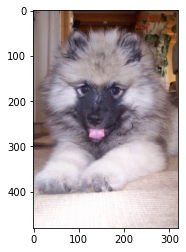

In [138]:
plt.imshow(plt.imread(image_path));

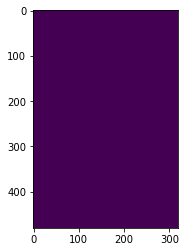

In [145]:
plt.imshow(mask);

In [148]:
# aws sagemaker list-endpoints --region eu-west-2

SyntaxError: invalid syntax (<ipython-input-148-bacce83a8a4b>, line 1)

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [152]:
#deployed_model.delete_endpoint("semantic-segmentation-2022-02-15-13-20-39-636")

#sagemaker.Session().delete_endpoint(deployed_model.endpoint_name)

sagemaker.Session().delete_endpoint("semantic-segmentation-2022-02-15-13-20-39-636")

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:eu-west-2:730456550509:endpoint/semantic-segmentation-2022-02-15-13-20-39-636".